In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


True noise variance (sigma2): 0.2500


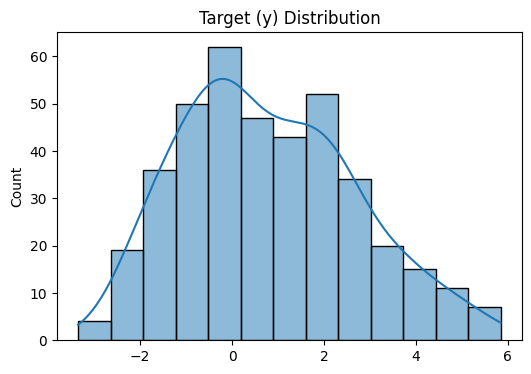

In [3]:
# Generate synthetic data with known noise level
import numpy as np
np.random.seed(42)

def generate_synthetic_data(n_samples=10000, noise_std=0.5):
    # Generate input features
    X = np.random.uniform(-1.5, 1.5, (n_samples, 5))
    
    # Create a non-linear function
    # f(x) = 2*sin(2*x1) + x2^2 + 0.5*x1*x3 + x3
    true_f = (2 * np.sin(2 * X[:, 0]) + 
              X[:, 1]**2 + 
              0.5 * X[:, 0] * X[:, 2] + 
              X[:, 2])
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_samples)
    y = true_f + noise
    
    true_sigma2 = noise_std**2
    return X, y, true_sigma2

# Generate data
noise_std = 0.5  # Standard deviation
true_sigma2 = noise_std**2  # True variance = 0.25
print(f"True noise variance (sigma2): {true_sigma2:.4f}")

X, y, true_var = generate_synthetic_data(n_samples=400, noise_std=noise_std)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

In [4]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=1000, nskip=200, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1200/1200 [00:38<00:00, 31.24it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.156


In [5]:
import pandas as pd

# Collect move counts
selected = bart.sampler.move_selected_counts
success = bart.sampler.move_success_counts
accepted = bart.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

              selected  success  accepted  success_rate  mh_ratio  accept_rate
multi_grow       29972    29972      8991      1.000000  0.299980     0.299980
multi_prune      30301    28513      8836      0.940992  0.309894     0.291608
multi_change     47922    45123     18619      0.941593  0.412628     0.388527
multi_swap       11805     3805      1367      0.322321  0.359264     0.115798


## Default BART

In [6]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=1000, nskip=200, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1200/1200 [00:04<00:00, 248.26it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.142


In [7]:
import pandas as pd

# Collect move counts
selected = bart_default.sampler.move_selected_counts
success = bart_default.sampler.move_success_counts
accepted = bart_default.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

        selected  success  accepted  success_rate  mh_ratio  accept_rate
grow       29857    29857      8018      1.000000  0.268547     0.268547
prune      29880    28170      7873      0.942771  0.279482     0.263487
change     48127    45301     11931      0.941280  0.263372     0.247907
swap       12136     3932      1397      0.323995  0.355290     0.115112


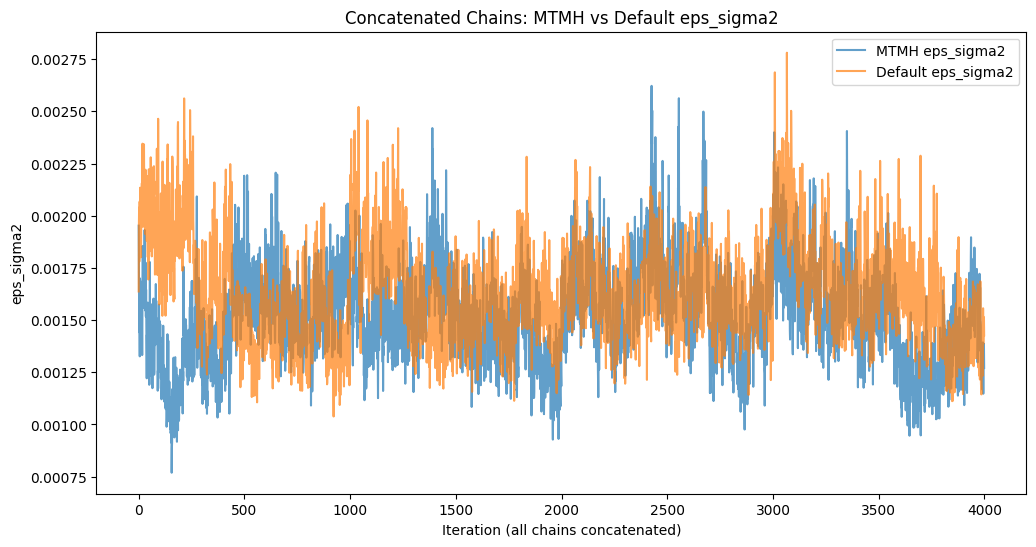

In [8]:
mtmh_long = np.concatenate(chains_mtmh)
default_long = np.concatenate(chains_default)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mtmh_long, label='MTMH eps_sigma2', alpha=0.7)
plt.plot(default_long, label='Default eps_sigma2', alpha=0.7)
plt.xlabel('Iteration (all chains concatenated)')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Concatenated Chains: MTMH vs Default eps_sigma2')
plt.show()